## Pre-Processing

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#%#run json_to_csv_converter.py "Data/yelp_academic_dataset_business.json"
#%run json_to_csv_converter.py "Data/yelp_academic_dataset_review.json"

In [2]:
import time
import datetime

import cPickle as pickle
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pylab
import re
import scipy as sp
import seaborn

from gensim import corpora, models
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.lda import LDA
from sklearn.qda import QDA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

plt.rc('figure', figsize=(10,6))
seaborn.set()
colors = seaborn.color_palette()

C:\Users\Karan\Anaconda2\lib\site-packages\gensim\utils.py:840: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Karan\Anaconda2\lib\site-packages\gensim\utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")
C:\Users\Karan\Anaconda2\lib\site-packages\sklearn\lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
C:\Users\Karan\Anaconda2\lib\site-packages\sklearn\qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


In [3]:
business_data = pd.read_csv("Data/yelp_academic_dataset_business.csv", dtype=unicode)
review_data = pd.read_csv("Data/yelp_academic_dataset_review.csv")

In [4]:
len(review_data)

2685066

In [5]:
len(business_data)

85901

In [30]:
resto_business_data = business_data[business_data['categories'].str.contains('Restaurants')]

In [31]:
len(resto_business_data)

26729

In [86]:
resto_review_data = review_data.merge(resto_business_data,
                                         left_on='business_id',
                                         right_on='business_id',
                                         suffixes=('_review', '_business'))

In [87]:
len(resto_review_data)

1630712

In [88]:
list(resto_review_data)

['user_id',
 'review_id',
 'text',
 'votes.cool',
 'business_id',
 'votes.funny',
 'stars_review',
 'date',
 'type_review',
 'votes.useful',
 'attributes.Ambience.divey',
 'attributes.Dietary Restrictions.vegan',
 'attributes.Happy Hour',
 'hours.Thursday.open',
 'attributes.Order at Counter',
 'attributes.Hair Types Specialized In.africanamerican',
 'attributes.Hair Types Specialized In.kids',
 'attributes.BYOB',
 'hours.Friday.open',
 'attributes.Good For.latenight',
 'attributes.Outdoor Seating',
 'attributes.Alcohol',
 'attributes.Ambience.classy',
 'attributes.By Appointment Only',
 'attributes.Parking.lot',
 'attributes.Ambience.touristy',
 'attributes.Corkage',
 'hours.Tuesday.open',
 'attributes.Good For.brunch',
 'categories',
 'attributes.Waiter Service',
 'hours.Monday.open',
 'name',
 'attributes.Parking.street',
 'attributes.Ambience.hipster',
 'attributes.BYOB/Corkage',
 'attributes.Hair Types Specialized In.straightperms',
 'attributes.Music.live',
 'attributes.Dietary R

In [89]:
resto_review_data = resto_review_data.ix[:,['text','stars_review']]

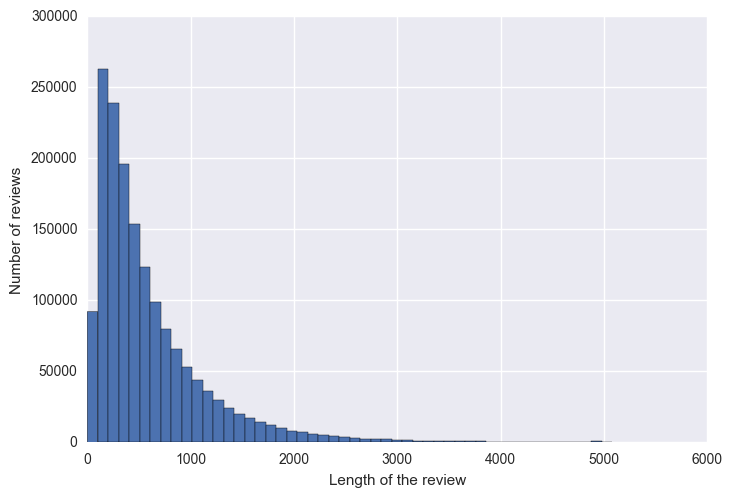

In [79]:
resto_review_data.text.dropna().str.len().hist(bins=50)
xlabel('Length of the review')
ylabel('Number of reviews')

In [90]:
minReviewLen = 50
resto_review_reduced = resto_review_data[resto_review_data.text.str.len() > minReviewLen]

In [91]:
len(resto_review_reduced)

1610512

In [92]:
maxReviewLen = 500
resto_review_reduced = resto_review_reduced[resto_review_reduced.text.str.len() < maxReviewLen]

In [93]:
len(resto_review_reduced)

910340

In [94]:
resto_review = resto_review_reduced

In [95]:
resto_review.stars_review = resto_review.stars_review.astype(float)

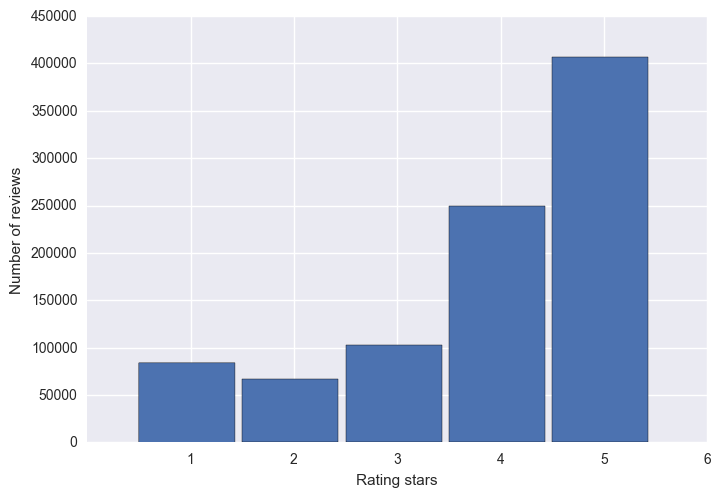

In [96]:
bins = [1, 2, 3 ,4, 5, 6]
resto_review.stars_review.hist(bins=bins, align='left', width=0.93)
xticks(bins)
xlabel('Rating stars')
ylabel('Number of reviews')
plt.show()

## Baseline Model

In [98]:
resto_review['predicted_rating'] = round(sum(resto_review.stars_review)/len(resto_review.index))
print "Baseline Rating:", round(sum(resto_review.stars_review)/len(resto_review.index))

Baseline Rating: 4.0


In [100]:
len(resto_review)

910340

In [108]:
precision = metrics.precision_score(resto_review.stars_review, resto_review.predicted_rating)
recall = metrics.recall_score(resto_review.stars_review, resto_review.predicted_rating)
f1 = metrics.f1_score(resto_review.stars_review, resto_review.predicted_rating)
accuracy = accuracy_score(resto_review.stars_review, resto_review.predicted_rating)

baselineResult = {}

data = {'precision':precision,
        'recall':recall,
        'f1_score':f1,
        'accuracy':accuracy}

baselineResult['Baseline'] = data
pd.DataFrame(baselineResult).T

C:\Users\Karan\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\Karan\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weig

,accuracy,f1_score,precision,recall
Baseline,0.273578,0.117535,0.074845,0.273578


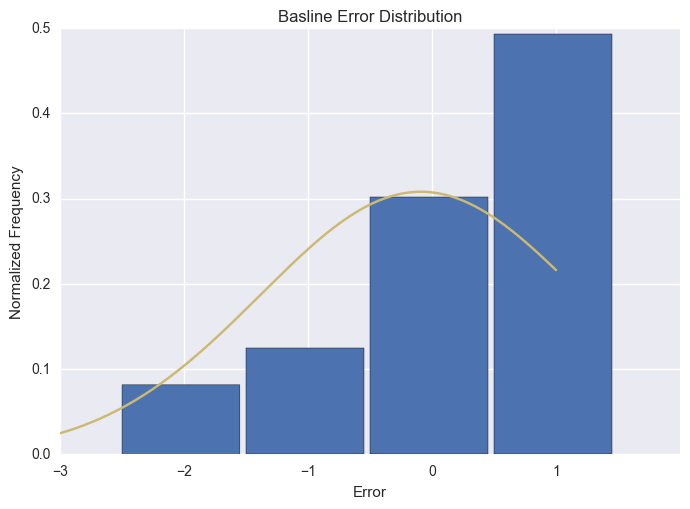

In [107]:
    error = resto_review.stars_review - resto_review.predicted_rating
    
    d = error.tolist()
    d = [0 if math.isnan(x) else x for x in d]
    m = mean(d)
    med = median(d)
    s = std(d)

    x = linspace(min(d), max(d), 1000)
    gauss = lambda x, m, s: (1 / (s * sqrt(2 * pi)) * exp(-0.5 * ((x - m) / s) ** 2))
    y = gauss(x, m, s)
    
    bins = np.arange(min(d), max(d)+1, 1)
    n, b, patches = plt.hist(d, bins=bins+1, normed=True, align='left', width=0.95)
    xticks(bins)
    
    plt.legend(loc=0)
    plt.plot(x, y, color=colors[4])
    plt.xlabel('Error')
    plt.ylabel('Normalized Frequency')
    title = 'Basline Error Distribution'
    plt.title(title)
    plt.show()

## Advanced models

In [110]:
stoplist = set(stopwords.words("english"))

In [111]:
numTopics = 15

In [113]:
starsGroup = resto_review.groupby('stars_review')

all_1stars_text = starsGroup.get_group(1.0)['text']
all_2stars_text = starsGroup.get_group(2.0)['text']
all_3stars_text = starsGroup.get_group(3.0)['text']
all_4stars_text = starsGroup.get_group(4.0)['text']
all_5stars_text = starsGroup.get_group(5.0)['text']

all_1stars_labels = [1.0]*len(all_1stars_text)
all_2stars_labels = [2.0]*len(all_2stars_text)
all_3stars_labels = [3.0]*len(all_3stars_text)
all_4stars_labels = [4.0]*len(all_4stars_text)
all_5stars_labels = [5.0]*len(all_5stars_text)

In [120]:
from sklearn.cross_validation import train_test_split

all_1stars_text_train, all_1stars_text_test, all_1stars_labels_train, all_1stars_labels_test = train_test_split(all_1stars_text, all_1stars_labels, test_size=0.20)
all_2stars_text_train, all_2stars_text_test, all_2stars_labels_train, all_2stars_labels_test = train_test_split(all_2stars_text, all_2stars_labels, test_size=0.20)
all_3stars_text_train, all_3stars_text_test, all_3stars_labels_train, all_3stars_labels_test = train_test_split(all_3stars_text, all_3stars_labels, test_size=0.20)
all_4stars_text_train, all_4stars_text_test, all_4stars_labels_train, all_4stars_labels_test = train_test_split(all_4stars_text, all_4stars_labels, test_size=0.20)
all_5stars_text_train, all_5stars_text_test, all_5stars_labels_train, all_5stars_labels_test = train_test_split(all_5stars_text, all_5stars_labels, test_size=0.20)

In [127]:
def process_reviews(dirty_data_set):
    clean_data_set = []
    for review in dirty_data_set:
        # Remove punctuations
        review = re.sub(r'[^a-zA-Z]', ' ', review)
        # To lowercase
        review = review.lower()
        # Remove stop words
        texts = [word for word in review.lower().split() if word not in stoplist]
        try:
            clean_data_set.append(' '.join(texts))
        except:
            pass
    return clean_data_set

In [128]:
corpus_5stars = process_reviews(all_5stars_text_train)
corpus_4stars = process_reviews(all_4stars_text_train)
corpus_3stars = process_reviews(all_3stars_text_train)
corpus_2stars = process_reviews(all_2stars_text_train)
corpus_1stars = process_reviews(all_1stars_text_train)

print "Number of 5-star reviews after processing: ", len(corpus_5stars)
print "Number of 4-star reviews after processing: ", len(corpus_4stars)
print "Number of 3-star reviews after processing: ", len(corpus_3stars)
print "Number of 2-star reviews after processing: ", len(corpus_2stars)
print "Number of 1-star reviews after processing: ", len(corpus_1stars)

Number of 5-star reviews after processing:  325603
Number of 4-star reviews after processing:  199239
Number of 3-star reviews after processing:  82408
Number of 2-star reviews after processing:  53890
Number of 1-star reviews after processing:  67131


In [129]:
corpus_5stars

['best fish burrito ever good beer selection definitely looking forward coming back trying items',
 'discovered place first moved become addicted vegetarian grilled veggie wrap yummy friends told subs delicious well especially get mike way jersey mike favorite though staff always super friendly packer fans always come wrap watch packer game feel home',
 'worth wait like everyone else think place fantastic well remember french name want eat everything looks good bring things breakfast great stuff lady says control good also bring coffee beer pretty ideal noon',
 'place pretty hard beat bacon cheese burger cheese fries good happy hometown getting shake shack',
 'love place pittsburgh different fun people working always seem great time good vibes great food ps get mexican corn cob make ressie show always packed',
 'bruschetta amazing finest ingredients lovely setting kindest service gem organic remarkable first visit',
 'place amazing best pad thai ever also fairly inexpensive especially 

In [130]:
all_5_4_train = np.append(corpus_5stars, corpus_4stars)
all_5_4_3_train = np.append(all_5_4_train, corpus_3stars)
all_5_4_3_2_train = np.append(all_5_4_3_train, corpus_2stars)
all_text_train = np.append(all_5_4_3_2_train, corpus_1stars)

In [132]:
len(all_text_train)

728271

In [135]:
len(resto_review)*.8

728272.0

In [136]:
all_text_train

array([ 'best fish burrito ever good beer selection definitely looking forward coming back trying items',
       'discovered place first moved become addicted vegetarian grilled veggie wrap yummy friends told subs delicious well especially get mike way jersey mike favorite though staff always super friendly packer fans always come wrap watch packer game feel home',
       'worth wait like everyone else think place fantastic well remember french name want eat everything looks good bring things breakfast great stuff lady says control good also bring coffee beer pretty ideal noon',
       ...,
       'terrible service server rude took minutes get drink order forget food really wanted try worth wait terrible servicio mesera de mal humor grosera se tardan en atenderte para las bebidas ya ni hablar de la comida vale la pena',
       'one servers rude looks like guy blond hair ordering kept interrupting saying would order finishing food one bussed boys tried take vape juice luckily caught bot

In [144]:
def perform_lda(allReviewsTrain, numTopics):
    corpus = []
    for review in allReviewsTrain:
        # Remove punctuations
        review = re.sub(r'[^a-zA-Z]', ' ', review)
        # To lowercase
        review = review.lower()
        # Remove stop words
        texts = [word for word in review.lower().split() if word not in stoplist]
        try:
            corpus.append(texts)
        except:
            pass

    # Build dictionary
    dictionary = corpora.Dictionary(corpus)
    dictionary.save('restaurant_reviews.dict')
        
    # Build vectorized corpus
    corpus_2 = [dictionary.doc2bow(text) for text in corpus]
    #corpora.MmCorpus.serialize('LDA/restaurant_reviews.mm', corpus_2)
    print(corpus_2)
    
    lda = models.LdaModel(corpus_2, num_topics=numTopics, id2word=dictionary)
    return lda

In [ ]:
%time lda = perform_lda(all_text_train, numTopics)